In [136]:
import numpy as np
from numpy.fft  import fft2, ifft2
from model import layers, activations, networks, utils, optimizers, losses, metrics, paddings
import matplotlib.pyplot as plt
import os
from PIL import Image

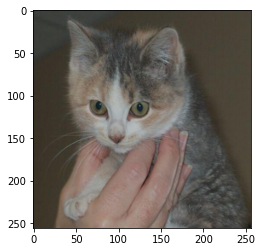

In [137]:
filepath = 'datasets\\catsanddogs\\Petimages\\Cat'
image_rgb = Image.open(filepath + '\\' + os.listdir(filepath)[7])
image_resized = image_rgb.resize((256, 256))
image = np.asarray(image_resized) / 255

plt.imshow(image, cmap='gray')

In [138]:
kernel = np.random.randint(-1, 1, (64, 3, 5, 5))

In [139]:
# %%timeit
p1 = int(kernel.shape[2] / 2)
c_scipy = np.zeros((image.shape[0] - 2 * p1, image.shape[0] - 2 * p1, kernel.shape[0]))
for k in np.arange(kernel.shape[0]):
    for c in np.arange(image.shape[2]):
        c_scipy[:, :, k] += utils.convolve_scipy(image[:, :, c], kernel[k, c])

# lambda?

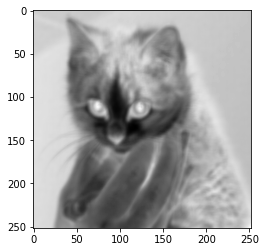

In [140]:
plt.imshow(c_scipy[:, :, 0], cmap='gray')

I further optimized the code shown here #https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html to create my own version of fft convolution.
Performance-wise it gets very close to scipys convolution, but has the advantage of being able to convolve higher dimensional Arrays that are used in CNNs

In [141]:
def convolve_fft(image, kernel): # array shape (h, w, c), kernel shape (k, c, h, w)
    C = np.zeros((*image.shape[:2], kernel.shape[0]))
    kernel_fft = np.moveaxis(fft2(kernel, s=image.shape[:2]), 1, -1)
    image_fft = fft2(image, axes=(0, 1))
    for k in np.arange(kernel.shape[0]):
        C[:, :, k] = np.sum(np.real(ifft2(image_fft * kernel_fft[k], axes=(0, 1))), axis=2)
    p = int(kernel.shape[2] / 2)
    return C[p : -p, p : -p]

In [142]:
# %%timeit
c_1 = convolve_fft(image, kernel)

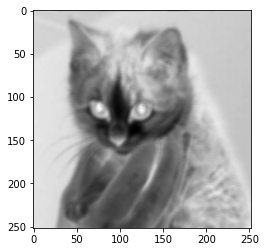

In [143]:
plt.imshow(c_1[:, :, 0], cmap='gray')

output shape fft

In [144]:
a = np.random.randint(0, 255, (5, 5))
a

array([[ 60, 139,  29,  92, 251],
       [156, 181,  53,   9, 252],
       [128, 217, 221, 187,  82],
       [ 80, 136,  28, 225, 119],
       [166, 213, 244,  10,  42]])

In [145]:
kernel2 = np.random.randint(0, 10, (4, 4))

In [146]:
import math
p2 = kernel2.shape[0] - 1
p2

3

In [147]:
c = utils.convolve_2d_fft(a, kernel2)
c

array([[ 9166.,  9540.,  9747., 10288.,  9433.],
       [ 6263.,  8964.,  8046.,  9444.,  9370.],
       [ 6821.,  9602., 10584.,  9096.,  9848.],
       [ 8636., 10814.,  8653.,  9071.,  9122.],
       [ 8614.,  9984.,  8009.,  9870., 10095.]])

In [148]:
c[p2:, p2:]

array([[ 9071.,  9122.],
       [ 9870., 10095.]])

In [149]:
d = utils.convolve_scipy(a, kernel2)
d

array([[ 9071,  9122],
       [ 9870, 10095]])